In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [3]:
EPOCHS = 100
BS = 16
default_image_size = tuple((300, 300))
directory_root = '/content/drive/MyDrive/PLDD Project/PLDD Dataset'

In [4]:

import os
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array

# Define required variables
directory_root = "/content/drive/MyDrive/PLDD Project/PLDD Dataset"  # Set correct path
default_image_size = (300, 300)  # Set the desired image size

# Function to convert image to array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    root_dir = os.listdir(directory_root)

    for directory in root_dir:
        if directory == ".DS_Store":
            root_dir.remove(directory)

    for plant_folder in root_dir:
        plant_folder_path = os.path.join(directory_root, plant_folder)
        if not os.path.isdir(plant_folder_path):  # Ensure it's a directory
            continue

        plant_disease_folder_list = os.listdir(plant_folder_path)
        for disease_folder in plant_disease_folder_list:
            if disease_folder == ".DS_Store":
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            plant_disease_folder_path = os.path.join(plant_folder_path, plant_disease_folder)
            if not os.path.isdir(plant_disease_folder_path):  # Ensure it's a directory
                continue

            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = os.listdir(plant_disease_folder_path)

            for single_plant_disease_image in plant_disease_image_list:
                image_directory = os.path.join(plant_disease_folder_path, single_plant_disease_image)

                if not os.path.isfile(image_directory):  # Ensure it's a file before processing
                    continue

                if image_directory.endswith((".jpg", ".JPG")):
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error: {e}")


[INFO] Loading images ...
[INFO] Processing healthy ...
[INFO] Processing BLB ...
[INFO] Processing Blast ...
[INFO] Processing hispa ...
[INFO] Processing leaf folder ...
[INFO] Processing leaf spot ...
[INFO] Image loading completed


In [5]:
image_size = len(image_list)

label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer, open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print(label_binarizer.classes_)

np_image_list = np.array(image_list, dtype=np.float16) / 255.0  # Normalize the pixel values

print("[INFO] Splitting data into train and test sets")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state=42)

['BLB' 'Blast' 'healthy' 'hispa' 'leaf folder' 'leaf spot']
[INFO] Splitting data into train and test sets


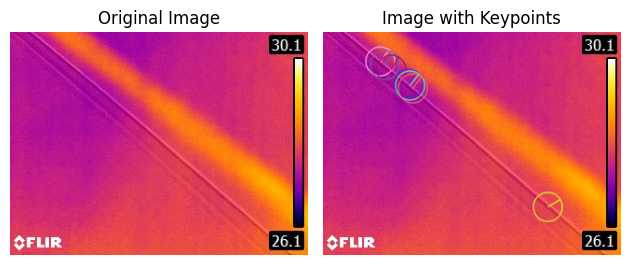

In [6]:
import cv2
def detect_keypoints(image_path):
    # Load the thermal image
    image = cv2.imread(image_path)
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Initialize the ORB detector
    orb = cv2.ORB_create()

    # Find keypoints and descriptors
    keypoints, descriptors = orb.detectAndCompute(gray, None)

    # Draw the keypoints on the image
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return image_with_keypoints, keypoints

if __name__ == "__main__":
    # Replace 'thermal_image.jpg' with the path to your thermal plant image
    image_path = '/content/drive/MyDrive/PLDD Project/PLDD Dataset/thermal images UL/healthy/thermalimage2a.jpg'

    # Detect keypoints in the thermal image
    result_image, keypoints = detect_keypoints(image_path)

    # Show the original and keypoints-annotated images
    plt.subplot(121), plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title('Original Image'), plt.axis('off')

    plt.subplot(122), plt.imshow(result_image[:, :, ::-1])
    plt.title('Image with Keypoints'), plt.axis('off')

    plt.tight_layout()
    plt.show()

In [7]:
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Define the path to the uploaded weights file
weights_path = "/content/drive/MyDrive/PLDD Project/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5"

# Load the model with local weights
if os.path.exists(weights_path):
    print("Loading local weights...")
    base_model = MobileNetV2(weights=weights_path, include_top=False, input_shape=(300, 300, 3))
else:
    print("Weights file not found. Downloading from TensorFlow repository...")
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

# Unfreeze the last 20 layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Create the model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Loading local weights...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_300 (Functional)    │ (None, 10, 10, 1280)        │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          81,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,340,358 (8.93 MB)

 Trainable params: 1,288,454 (4.92 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

In [8]:
def lr_schedule(epoch):
    initial_lr = 0.001
    if epoch < 15:
        return initial_lr
    else:
        return initial_lr / 100

# Create the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Fit the model
history = model.fit(x_train, y_train,
                    batch_size=BS,
                    epochs=EPOCHS,
                    validation_data=(x_test, y_test),
                    callbacks=[lr_scheduler])

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 518ms/step - accuracy: 0.3970 - loss: 2.7758 - val_accuracy: 0.4297 - val_loss: 4.9433 - learning_rate: 0.0010
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6948 - loss: 1.7319 - val_accuracy: 0.3906 - val_loss: 7.4439 - learning_rate: 0.0010
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7984 - loss: 1.3936 - val_accuracy: 0.3984 - val_loss: 8.3312 - learning_rate: 0.0010
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8706 - loss: 1.0159 - val_accuracy: 0.3984 - val_loss: 12.4420 - learning_rate: 0.0010
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9405 - loss: 0.7558 - val_accuracy: 0.4531 - val_loss: 14.6996 - learning_rate: 0.0010
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8977 - loss: 0.8292 - val_accuracy: 0.4062 - val_loss: 9.6692 - learning_rate: 0.0010
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9162 - loss: 0.774

In [9]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy}")

# Calculate precision, f1 score, and confusion matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')

print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9490 - loss: 0.2970
Test accuracy: 0.953125
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step
Test Precision: 0.9597
Test Recall: 0.9531
Test F1 Score: 0.9547


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


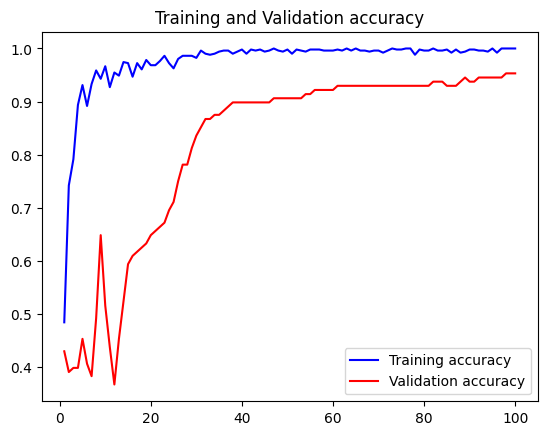

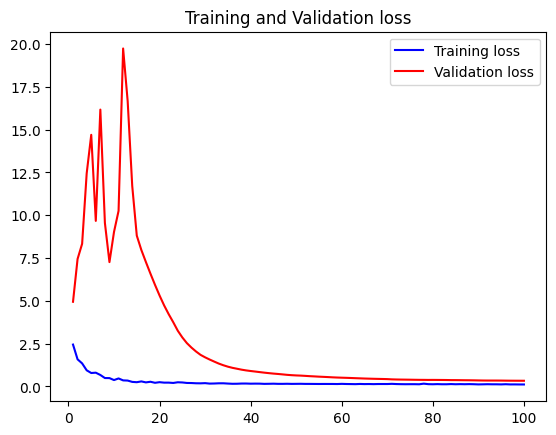

In [10]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [11]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9490 - loss: 0.2970
Test Accuracy: 95.3125


(1, 300, 300, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[[1.0000000e+00 7.4770878e-10 1.4893346e-10 2.8037248e-11 7.5234478e-11
  7.7345025e-10]]
Predicted Class: BLB
Probability: 1.0000


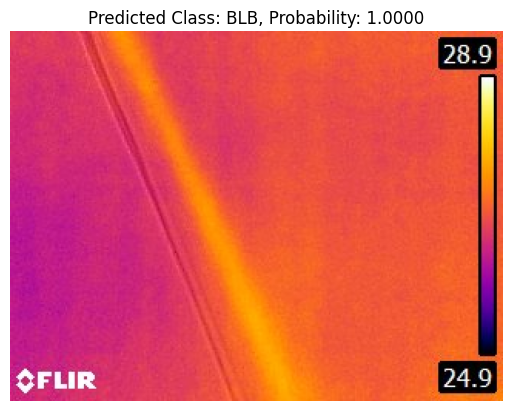

In [13]:
default_image_size = (300, 300)  # Change the default_image_size to match the model's input shape

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)  # Resize to (300, 300)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/content/drive/MyDrive/PLDD Project/PLDD Dataset/thermal images UL/BLB/thermalimage101b.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 300, 300, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
[[7.8770929e-05 9.9952567e-01 9.3587776e-05 2.7803602e-04 2.1347298e-06
  2.1919903e-05]]
Predicted Class: Blast
Probability: 0.9995


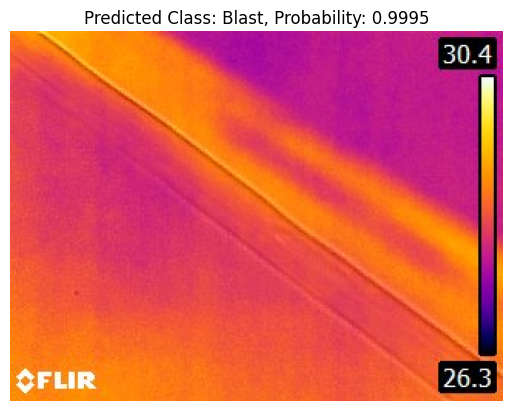

In [14]:
default_image_size = (300, 300)  # Change the default_image_size to match the model's input shape

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)  # Resize to (300, 300)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/content/drive/MyDrive/PLDD Project/PLDD Dataset/thermal images UL/Blast/Thermalimage10c.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 300, 300, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[6.9223288e-06 2.4050962e-06 9.9998951e-01 8.2668848e-08 1.4501792e-09
  1.0624111e-06]]
Predicted Class: healthy
Probability: 1.0000


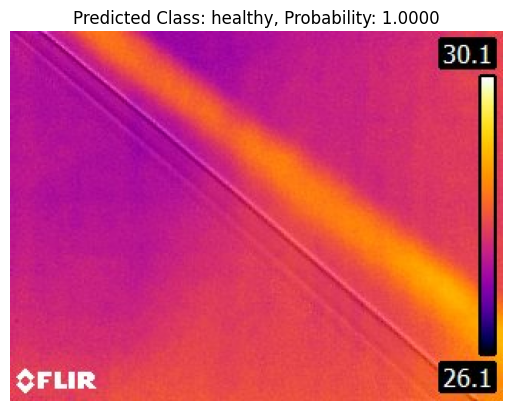

In [15]:
default_image_size = (300, 300)  # Change the default_image_size to match the model's input shape

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)  # Resize to (300, 300)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/content/drive/MyDrive/PLDD Project/PLDD Dataset/thermal images UL/healthy/thermalimage2a.jpg"

im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 300, 300, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[5.2594165e-05 5.1852567e-06 2.4795364e-07 5.5555038e-06 9.9978346e-01
  1.5305096e-04]]
Predicted Class: leaf folder
Probability: 0.9998


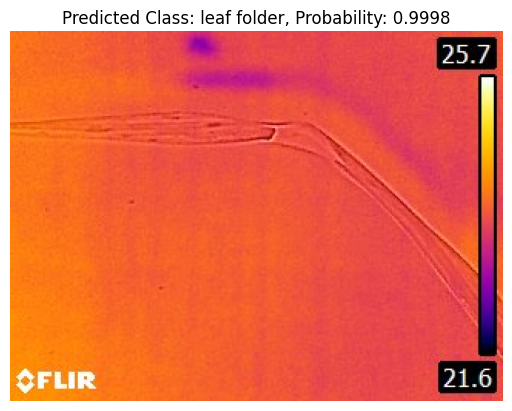

In [16]:
default_image_size = (300, 300)  # Change the default_image_size to match the model's input shape

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)  # Resize to (300, 300)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/content/drive/MyDrive/PLDD Project/PLDD Dataset/thermal images UL/leaf folder/thermalimage13a.jpg"
im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 300, 300, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[6.2720712e-05 8.4892351e-09 1.2684698e-09 9.9993706e-01 2.6371558e-07
  4.4046446e-09]]
Predicted Class: hispa
Probability: 0.9999


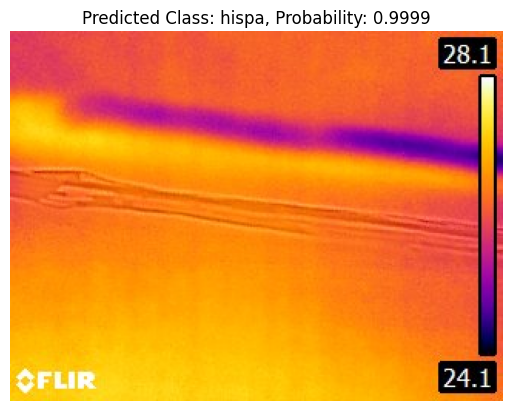

In [18]:
default_image_size = (300, 300)  # Change the default_image_size to match the model's input shape

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)  # Resize to (300, 300)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/content/drive/MyDrive/PLDD Project/PLDD Dataset/thermal images UL/hispa/thermalimage12b.jpg"
im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()

(1, 300, 300, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[3.4892790e-05 1.5262731e-05 7.7704382e-05 7.1130758e-06 1.5455571e-06
  9.9986351e-01]]
Predicted Class: leaf spot
Probability: 0.9999


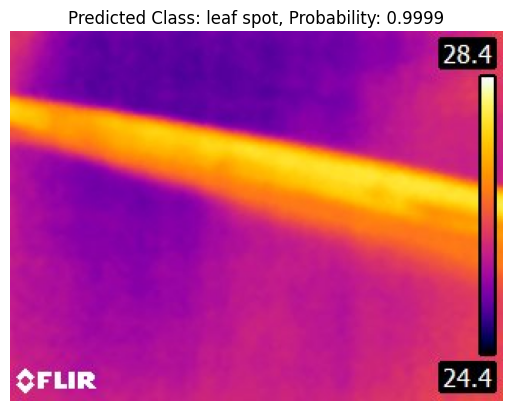

In [19]:
default_image_size = (300, 300)  # Change the default_image_size to match the model's input shape

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, default_image_size)  # Resize to (300, 300)
            return img_to_array(image)
        else:
            return np.array([])
    except Exception as e:
        print(f"Error: {e}")
        return None

image_dir = "/content/drive/MyDrive/PLDD Project/PLDD Dataset/thermal images UL/leaf spot/thermalimage10c.jpg"
im = convert_image_to_array(image_dir)
im = np.expand_dims(im, axis=0)  # Expand dimensions to match model input shape
np_image_li = np.array(im, dtype=np.float16) / 225.0

print(np_image_li.shape)

result = model.predict(np_image_li)
print(result)

# Assuming you have 'label_binarizer' defined for mapping class indices to class names.
# And 'class_names' defined as a list of class names in the same order as 'label_binarizer.classes_'.
class_names = label_binarizer.classes_  # Remove the enclosing square brackets

# Calculate the predicted class index and probability.
predicted_class_index = np.argmax(result)
probability = result[0][predicted_class_index]

# Get the predicted class name.
predicted_class_name = class_names[predicted_class_index]

print(f"Predicted Class: {predicted_class_name}")
print(f"Probability: {probability:.4f}")

# Display the image
image = cv2.imread(image_dir)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title(f"Predicted Class: {predicted_class_name}, Probability: {probability:.4f}")
plt.axis('off')
plt.show()